##### Brian Santeliz  TEG 2020


# Aplicación de la Arquitectura de redes neuronales (cGANS) para generar imagenes de fachadas utilizando el modelo Pix2Pix

## Importando TensorFlow y otras librerias


In [2]:
#IMPORTANDO LIBRERIAS 
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf # VERSION DE TENSORFLOW 2,0 IMPORTANTE!!
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

## 1. Cargando el DataSet

El dataset fue obtenido de --> [Aquí](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). Como se menciona en el paper [paper](https://arxiv.org/abs/1611.07004) Se aplicaco la funciones random jittering y random mirroring para el dataset de entrenamiento.
* La funcion random jittering, cambia el tamaño de las imagenes a `286 x 286` y luego es recortada a `256 x 256`
* la funcion random mirroring, La imagen es volteada aleatoriamente de forma horizontal de izquierda a derecha  

In [3]:
#OBTENIENDO LA URL DEL DATASET Y SE PROCEDE A DESCARGARLO
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

#EXTRAYENDO EL DATASET Y GUARDANDO EN UN VARIABLE
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)
#RUTA DEL DATASET DESCOMPRIMIDO
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 1s 0us/step


In [4]:
#CONSTANTES QUE SE UTLIZARAN A LO LARGO DEL CODIGO
# ESTAS SON HIPERPARAMETROS
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256 #ANCHO DE LAS IMAGENES
IMG_HEIGHT = 256 #LARGO DE LAS IMAGENES

In [5]:
#FUNCION DE CARGA 
def load(image_file):
  image = tf.io.read_file(image_file) #LEE LAS IMAGENES 
  image = tf.image.decode_jpeg(image) #DECODIFICA LAS IMAGENES A JPEG
 
  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

#CAST PARA PASARLA A FLOAT, ESTO ES UTIL PARA LOS CALCULOS
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

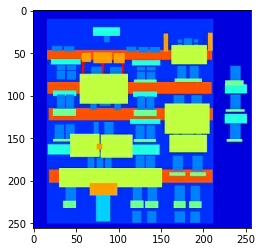

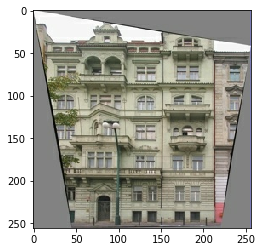

In [6]:
#CARGA LA IMAGEN DE ENTRANMIENTO 100
inp, re = load(PATH+'train/100.jpg')
# CASTING PARA INT PARA MATPLOLIB MUESTRA LA IMAGEN
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
#REDIMENZIONA LAS IMAGENES
#RECIBE COMO PARAMENTRO EL INPUT DE LA IMAGEN Y LOS TAMAÑOS
#SE USA LA FUNCION DE TF .RESIZE Y LAS RETORNA
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
#RECORTA UNA PARTE DE LA IMAGEN PASADa COMO PARAMENTRO
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# NORMALIZA LAS IMAGENES A UN RANGO DE  [-1, 1]
# COMO LAS IMAGENES SON DE 256 SE DIVIDE ENTRE 127.5 Y SE RESTA 1
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
# FUNCION PARA AUMENTAR EL DATASET DE IMAGENES
# SE AMPLIA LA IMAGEN Y RECORTARLA
@tf.function()
def random_jitter(input_image, real_image):
  # SE REDIMENZIONA A 286 x 286 x 3 (CANALES RGB)
  input_image, real_image = resize(input_image, real_image, 286, 286)

# TOMA UNA PARTE DE LA IMAGEN Y LA LLEVA (256 X 256 X 3)
# DE LAS IMAGENES AMPLIADAS A 286 x 286 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # FUNCION RANDOM MIRRONRING, VOLTEA LA IMAGEN HORIZONTALMENTE
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

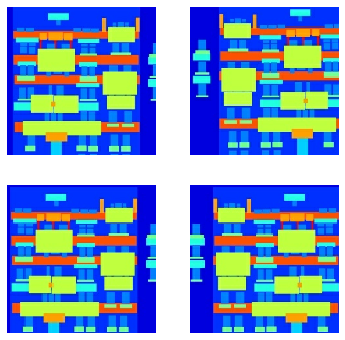

In [11]:
# COMO SE PUEDE APRECIAR EN LAS IMAGENES ABAJO
# ESTAS PASAN A TRAVES DE LAS FUNCIÓN RANDOM JITTERING
# ESTA FUNCION COMO SE DESCRIBE EN EL PAPER ES PARA:
# 1. REDIMENZIONAR UNA IMAGEN AUMENTANDO SU ANCHO Y ALTO
# 2. RECORTA ESTA IMAGEN AL TAMAÑO ORIGINAL
# 3. ES VOLTEADO ALEATORIAMENTE DE FORMA HORIZONTAL

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [12]:
# FUNCION PARA CARGAR LAS IMAGENES DE ENTRENAMIENTO
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
# FUNCION PARA CARGAR LAS IMAGENES DE TEST.
# EN ESTA FUNCION NO SE APLICA LA FUNCION RANDOM JITTER
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Tunel de Entrada para entranamiento y testing (Input Pipeline)


In [14]:
# DEFININEDO LAS VARIBALES PARA EL DATASET DE ENTRENAMIENTO
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

In [15]:
# DEFININEDO LAS VARIBALES PARA EL DATASET DE TEST
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

## 2. Construyendo el Generador
  * La arquitectura del generador es una U-NET modificada.
  
  * Cada bloque del encoder es una (RED Convolucional -> Batchnorm(normaliza la salida) -> Leaky ReLU (funcion de activacion))
  * Cada bloque del decoder es una (Red Convolucional Invertida -> Batchnorm -> Dropput(aplicado a los 3 primeros bloques -> ReLU)
  * Existen Skip Connections entre el encoder y decoder (como las U-Net).

In [16]:
# DEFINIENDO LOS CANALES DE SALIDA RGB
OUTPUT_CHANNELS = 3

In [17]:
#FUNCION PARA CONSTRUIR LAS CAPAS DEL GENERADOR 
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
# AÑADE LA CAPA CONVOLUCIONAL
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
# AÑADE LA CAPA NORMALIZACION
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
    
# AÑADE LA FUNCION DE ACTIVACION LeakyReLU 
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
#PROBANDO EL ENCODER
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [19]:
#FUNCION PARA CONSTRUIR LAS CAPAS DEL DECODIFICADOR 
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
# AÑADE LA CAPA CONVOLUCIONAL INVERSA
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

# AÑADE LA CAPA NORMALIZACION
  result.add(tf.keras.layers.BatchNormalization())
    
# AÑADE LA CAPA DE DROPOUT 
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

# AÑADE LA FUNCION DE ACTIVACION ReLU 
  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
#PROBANDO EL DECODER
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [21]:
#CONSTRUYENDO EL GENERADOR ES UNA U-NET MODIFICADA
def Generator():
  down_stack = [
   # LLAMA LA FUNCION DOWNSAMPLE Y ENVIA LOS PARAMENTROS PARA CONSTRUIR LAS 8 CAPAS
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    # LLAMA LA FUNCION UPSAMPLE Y ENVIA LOS PARAMENTROS PARA CONSTRUIR LAS 7 CAPAS
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
# CAPA CONVOLUCIONAL PARA LA IMAGEN QUE QUEREMOS GENERAR
# SE ESPECIFICA OUTPUT_CHANNELS (TRES CANALES DE COLOR)
# EL TIPO DE ACTIVACION DEBE SER PARECIDO A LA NORMALIZACION [1,-1] QUE SE DEFINIO
# LA CAPA DE ACTIVACION QUE CUMPLE ESTO ES TANH
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
# CONCATENA LAS CAPAS DEL CODIFICADOR
  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

# DOWNSAMPLING A TRAVES DEL MODELO, 
# ES DECIR CONECTA LAS CAPAS AL CODIFICADOR
# SE GUARDA LS DIFERENTES ELEMENTO EN UN ARREGLO PARA LOS SKIP CONNECTIONS
# SON CONEXIONES QUE SE SALTA EL PROCESAMIENTO DE ALGUNAS CAPAS
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x) #AGREGANDO AL ARRAY LOS ELEMENTOS

# LA ULTIMA CAPA DEBE SER LA PRIMERA EN EL DECODIFICADOR
  skips = reversed(skips[:-1])

# UPSAMPLING Y ESTABLECIENDO LAS SKIP CONNECTIONS, 
# ES DECIR CONECTA LAS CAPAS AL DECODIFICADOR
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip]) #CONCATENA EL RESULTADOS DE LAS DOS CAPAS CON KERAS

  x = last(x)
# DEVUELVE EL MODELO COMPUESTO POR LAS CAPAS CREDAS
  return tf.keras.Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


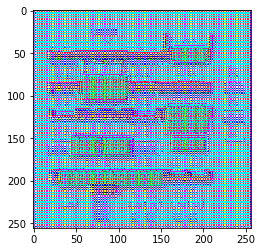

In [22]:
# PROBANDO EL GENERADOR 
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

## 3. Construyendo el Discriminador
  * El discriminador es una PatchGAN.
  * Cada bloque en el discriminador es  (Convolucional -> BatchNorm -> Leaky ReLU)
  * La forma de la salida despues de la ultima capa es (batch_size, 30, 30, 1)
  * Cada parche 30x30 de la salida clasifica una porcion 70x70 de la imagen de entrada (esta arquitectura es llama PatchGAN).
  * Discriminador recibe 2 inputs.
    * Una imagen de entrada y su resultado, que deberia clasificar como real.
    * Una imagen de entrada y la imagen generada (salida del generador), que deberia clasificar como fake.
    * Concatena esas 2 entradas juntas en el codigo (`tf.concat([inp, tar], axis=-1)`)

In [23]:
# FUNCION PARA CONSTRUIR EL DISCRIMINADOR
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image') # IMAGEN DE ENTRADA REAL
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image') # IMAGEN DEL GENERADOR

# CONCATENANDO LAS DOS IMAGENES
  x = tf.keras.layers.concatenate([inp, tar]) 

# CONSTRUYENDO LOS DISTINTOS BLOQUES 
  down1 = downsample(64, 4, False)(x) 
  down2 = downsample(128, 4)(down1) 
  down3 = downsample(256, 4)(down2) 
    
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
  
# AÑADE LA LA CAPA CONVOLUCIONAL
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

# AÑADE LA LA CAPA DE NORMALIZACION
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

# AÑADE LA FUNCTION DE ACTIVACION leakyReLU
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

# ULTIMA CAPA CON UNICO FILTRO DE SALIDA CON UN CANAL
# DONDE NOS DICE POR CADA PIXEL DE LA IMAGEN
# SI ES REAL O NO
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    
# DEVUELVE EL MODELO DEL DISCRIMINADOR
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

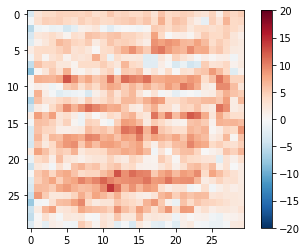

In [24]:
# PROBANDO EL DISCRIMINADOR
discriminator = Discriminator()
# PASA UNA IMAGEN Y SE COMPRUEBA EL RESULTADO
# AUN EL MODELO DISCRIMINADOR NO ESTA ENTRENADO
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## 4. Definiendo la función de perdida y el optimizador

* **Perdida del Discriminador**
  * La funcion de perdida del discriminador toma dos entradas; **imagenes reales, imagenes generadas**
  * real_loss es una función sigmoide de perdida llamada entropia cruzada corresponde a las **imagenes reales** y es un **array de unos. (estas son las imagenes reales)**
  * generated_loss es una función sigmoide de perdida llamada entropia cruzada corresponde a las **imagenes generadas** y es un **array de ceros (estas son las imagenes falsas)**
  * Implica que el total es la suma de real_loss y generated_loss 


* **Perdida del Generador**

  * Es una función sigmoide de perdida llamada entropia cruzada de las imagenes generadas y un **array de unos**.
  * En el [paper](https://arxiv.org/abs/1611.07004) de pix2pix además incluye funcion de perida L1 el cual es MAE (error absoluto medio) entre la imagen generada y el resultado de la imagen.
  
  * Esto permite que la imagen generada se vuelva estructuralemnte silimar a las imagenes objectivo. 
  
  * la formula para calcular la perdida del generador es  generator loss = gan_loss + LAMBDA * l1_loss, donde LAMBDA = 100. Este valor son los que recomiendan los autores del [paper](https://arxiv.org/abs/1611.07004).

In [25]:
# FUNCION LAMDA DEBE SER IGUAL A 100 
# ESTE ES UN HIPERPARAMETRO
LAMBDA = 100

In [26]:
# OBJETO PARA EVALUAR EL RESULTADO DE LAS IMAGENES QUE SE OBTIENE
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
# FUNCION PARA EVALUAR EL COMPORTAMIENTO DEL DISCRIMINADOR
def discriminator_loss(disc_real_output, disc_generated_output):
    
# DIFERENCIA ENTRE LA OBSERVACION DE UNA IMAGEN REAL Y UNA MATRIZ CON TODOS A UNOS
# ESTA MATRIZ REPRESENTA UNA IMAGEN REAL
real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

# DIFERENCIA ENTRE LA OBSERVACION DE UNA IMAGEN GENERADA Y UNA MATRIZ CON TODOS A CEROS
# ESTA MATRIZ REPRESENTA UNA IMAGEN FALSA.
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

# LA SUMA TOTAL EVALUA EL COMPORTAMIENTO DEL DISCRIMINADOR
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [28]:
# FUNCION PARA EVALUAR EL COMPORTAMIENTO DEL GENERADOR
# RECIBE COMO PARAMETRO LA SALIDA DEL EL DISCRIMINADOR, 
# LA IMAGEN GENERADA Y LA IMAGEN REAL
def generator_loss(disc_generated_output, gen_output, target):

# INVIERTE LA OPERACION DEL DISCRIMINADOR
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # ERROR ABSOLUTO MEDIO
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

# PARA LA SUMA SE USA EL HIPERPARAMETRO LAMBDA
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [29]:
# DEFINIENDO LOS OPTIMIZADORES
# EN ESTA CASO ES ADAM, UNA VARIACION 
# AL DESCENSO DEL GRADIENTE
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 5. Checkpoints

In [30]:
# CREANDO CHECKPOINTS PARA GUARDAR Y REANUDAR EL PUNTO DE ENTRAMIENTO
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6. Entrenamiento

* Comienza iterando sobre el dataset
* El generador obtiene unas imagenes de entrada y devuelve una salida generada.

* El discriminador recibe la  imagen generada como la primera entrada. La segunda entrada es el  target_image

* Despues, se calcula la perdida del generador y discriminador.
* Luego, se calcula los gradientes de perdida tanto para el generador y discriminador variables(inputs) y aplica el optimizador.



---

## Generando imagenes

* Despues del entramiento, es tiempo para generar algunas imagenes!
* Se pasa las imagenes del conjunto de prueba al generador
* El generador luego traducira la imagen de entrada en la salida esperada
* El ultimo paso es hacer plot a las predichas y **listo!**

In [31]:
#DEFINIENDO LAS EPOCAS DE ENTRENAMIENTO
EPOCHS = 150

In [32]:
# ESTA FUNCION SE ENCARGA DE EVALUAR AL GENERADOR QUE SE ESTA ENTRENANDO
# RECIBE COMO PARAMETRO LAS IMAGENES DEL CONJUNTO DE PRUEBA
def generate_images(model, test_input, tar):
  # EL TRAINING = True ES INTENCIONAL
  # SE QUIERE LAS ESTADISTICAS DE BATCH MIENTRAS SE EJECUTA EL MODELO
  # En el dataset de prueba. SI SE USA training=False, 

# EL ACUMULADOR DE ESTADISTICAS APRENDE DEL DATASET DE ENTRENAMIENTO
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # OBTENIENDO EL VALOR DEL PIXER ENTRE [0, 1] PARA REALIZAR.

    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [33]:
# FUNCION QUE ENLAZA TODOS LOS MODULOS IMPLEMENTADOS
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
# EL GENERADOR TOMA LA IMAGEN DE ENTRADA DE LA FUNCION. ESTA IMAGEN ES COMPRIMIDA
# POR EL ENCODER Y DESCOMPRIMIDA POR EL DECODER Y OBTENEMOS UNA IMAGEN DE SALIDA
    gen_output = generator(input_image, training=True)

# EL DISCRIMINADOR RECIBE LA IMAGEN REAL Y LA IMAGEN GENERADA 
# Y DEVUELVE UNA SALIDA 
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

# SE LLAMA LAS FUNCIONES DE PERDIDA generator_loss Y discriminator_loss
# PARA EVALUAR EL COMPORTAMIENTO DE AMBOS MODELOS
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
# ALMACENA EL GRADIENTE DEL GENERADOR
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
# ALMACENA EL GRADIENTE DEL DISCRIMINADOR
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
#APLICA EL OPTIMIZADOR BASADO EN EL GRADIENTE PARA EL GENERADOR
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    
#APLICA EL OPTIMIZADOR BASADO EN EL GRADIENTE PARA EL DISCRIMINADOR
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [34]:
# FUNCION PARA EL ENTRENAMIENTO RECIBE EL DATASET DE 
# ENTRANMIENTO, EPOCAS, Y DATASET DE PRUEBA
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # FOR LOOP PARA EL ENTRENAMIENTO
    for input_image, target in train_ds:
      train_step(input_image, target)

    clear_output(wait=True)
    # PRUEBA LA MISMA IMAGEN PARA QUE EL PROGRESO DEL MODELO PUEDA SER
    # FACILMENTE VISTO
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)

    # GUARDA UN CHECKPOINT CADA 20 EPOCAS
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('El tiempo tomado para cada epoca {} es {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

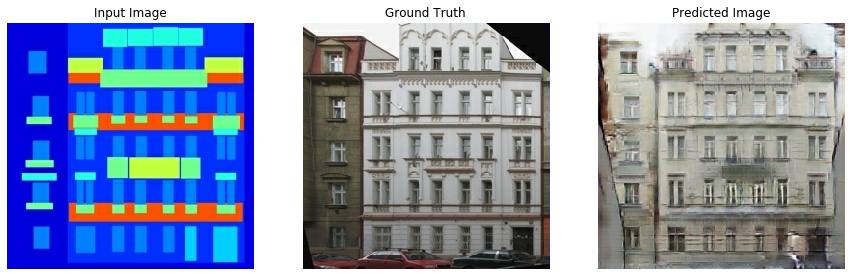

Time taken for epoch 150 is 14.623376607894897 sec



In [35]:
# ENTRENANDO EL MODELO
fit(train_dataset, EPOCHS, test_dataset)

## 7. Restaurando el ultimo checkpoint

In [36]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.data-00001-of-00002
ckpt-1.data-00000-of-00002  ckpt-4.index
ckpt-1.data-00001-of-00002  ckpt-5.data-00000-of-00002
ckpt-1.index		    ckpt-5.data-00001-of-00002
ckpt-2.data-00000-of-00002  ckpt-5.index
ckpt-2.data-00001-of-00002  ckpt-6.data-00000-of-00002
ckpt-2.index		    ckpt-6.data-00001-of-00002
ckpt-3.data-00000-of-00002  ckpt-6.index
ckpt-3.data-00001-of-00002  ckpt-7.data-00000-of-00002
ckpt-3.index		    ckpt-7.data-00001-of-00002
ckpt-4.data-00000-of-00002  ckpt-7.index


In [ ]:
# RESTAURANDO EL ULTIMO CHECKPOINT EN EL DIRECTORIO
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 8. Generando usando el dataset de prueba

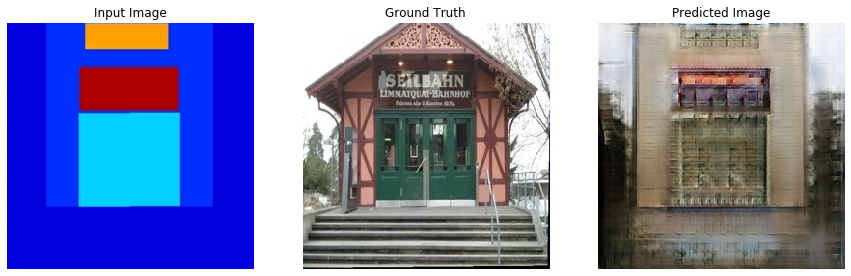

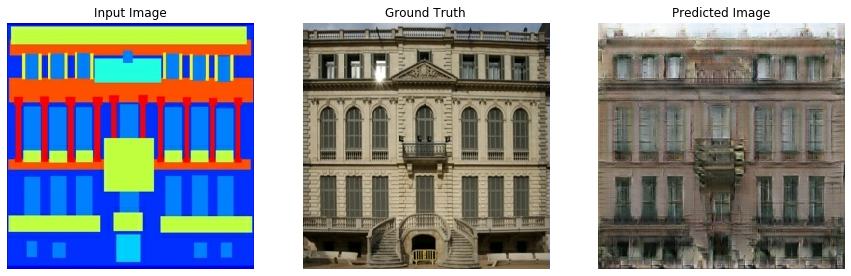

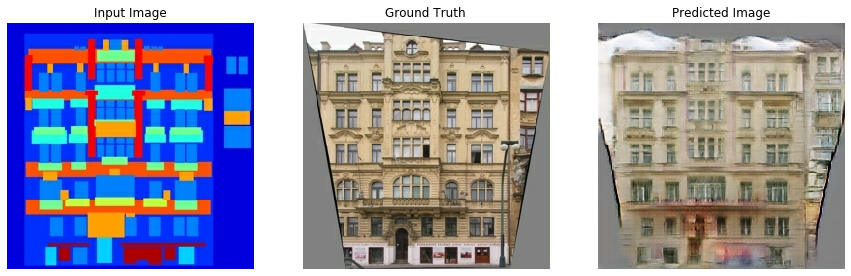

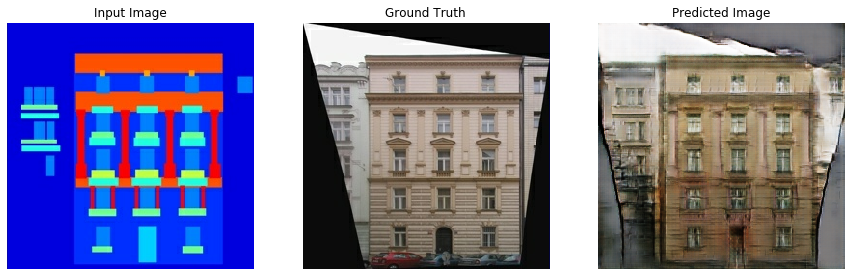

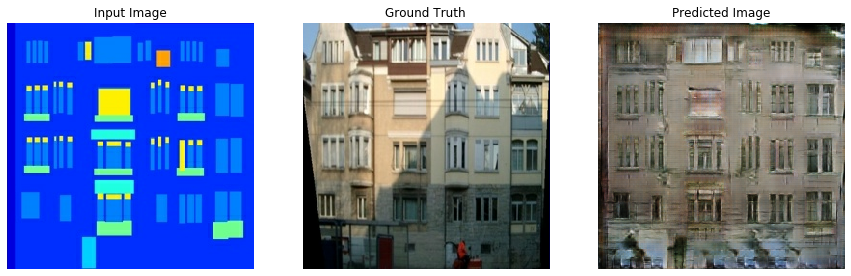

In [38]:
# EJECUTA EL MODEL ENTRENADO CON EL DATASET DE TEST
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)